# British Airlines Project

## Part 1. Collecting data

The data will be obtained from [Skytrax](https://www.airlinequality.com). Let's start composing the script

In [1]:
# import libraries

from bs4 import BeautifulSoup
import requests
import pandas as pd

In [2]:
PAGES_COUNT = 37
PAGE_SIZE = 100
URL = "https://www.airlinequality.com/airline-reviews/british-airways"

page_counter = 0
encountered_error = False
review_data = []
while not encountered_error and page_counter < PAGES_COUNT:
    requested_url = f"{URL}/page/{page_counter + 1}/?sortby=post_date%3ADesc&pagesize={PAGE_SIZE}"
    response = requests.get(requested_url)
    print(f"Requesting page {page_counter + 1} out of {PAGES_COUNT}")
    if response.status_code != 200:
        encountered_error = True
        print(f"Something went wrong!")
        break
    else:
        print("Request is successful!")
        content = BeautifulSoup(response.content, "lxml")
        reviews = content.find_all("div", {"class": "text_content"})
        for review in reviews:
            review_data.append(review.get_text())
        page_counter+=1

Requesting page 1 out of 37
Request is successful!
Requesting page 2 out of 37
Request is successful!
Requesting page 3 out of 37
Request is successful!
Requesting page 4 out of 37
Request is successful!
Requesting page 5 out of 37
Request is successful!
Requesting page 6 out of 37
Request is successful!
Requesting page 7 out of 37
Request is successful!
Requesting page 8 out of 37
Request is successful!
Requesting page 9 out of 37
Request is successful!
Requesting page 10 out of 37
Request is successful!
Requesting page 11 out of 37
Request is successful!
Requesting page 12 out of 37
Request is successful!
Requesting page 13 out of 37
Request is successful!
Requesting page 14 out of 37
Request is successful!
Requesting page 15 out of 37
Request is successful!
Requesting page 16 out of 37
Request is successful!
Requesting page 17 out of 37
Request is successful!
Requesting page 18 out of 37
Request is successful!
Requesting page 19 out of 37
Request is successful!
Requesting page 20 ou

In [3]:
len(review_data)

3606

We got 3602 reviews. Let's see the structure of one of the reviews

In [4]:
review_data[0]

'✅ Trip Verified |  Flight was delayed due to the inbound flight arriving late. There was no announcement to inform of the delay nor were the sceens updated. When ready to board we were requested to take our seats quickly to help reduce the delay, which people did. The pilot then announced he had received the documents for the wrong flight from ground staff, so we had to wait while they returned to get the right paperwork. After this was resolved, the pilot announced there would be a delay as there was only two push back tractors and we had to wait again. So after rushing to sit quickly, we sat the the aircraft at the gate for nearly one hour, which is longer than the flight takes ! Of course AMS is not BAs home base and it uses contracted staff here, but it should require a better level of service, It was embarrassing hearing the pilot apologise at every step of the way. It’ll be Eurostar for me next time.'

Nothing spectecular, just plain text. The "trip verified" part will not be needed, so we'll delete it later. Now let's save the data into csv

In [5]:
review_df = pd.DataFrame({"Review texts":review_data})
review_df.head()

,Review texts
0,✅ Trip Verified | Flight was delayed due to t...
1,Not Verified | Fast and friendly check in (to...
2,✅ Trip Verified | I don't understand why Brit...
3,Not Verified | I'm sure that BA have graduall...
4,✅ Trip Verified | Customer Service does not e...


In [6]:
review_df.to_csv("data/reviews.csv", index=False)

## Part 2. EDA with NLP

Having gathered the data, time to analyze it. Loading the data

In [7]:
import pandas as pd

review_df = pd.read_csv("data/reviews.csv")
review_df.head()

,Review texts
0,✅ Trip Verified | Flight was delayed due to t...
1,Not Verified | Fast and friendly check in (to...
2,✅ Trip Verified | I don't understand why Brit...
3,Not Verified | I'm sure that BA have graduall...
4,✅ Trip Verified | Customer Service does not e...


### Removing unnecessary part

Earlier we determined that we won't need the "trip verified" part. So we'll delete it in a moment. Also we'll delete any space characters in the beginnig and at the end of each review

In [8]:
review_df["Review texts"] = review_df["Review texts"].str.replace(".*\|", '', regex=True)
review_df["Review texts"] = review_df["Review texts"].str.strip()
review_df.head()

,Review texts
0,Flight was delayed due to the inbound flight a...
1,Fast and friendly check in (total contrast to ...
2,I don't understand why British Airways is clas...
3,I'm sure that BA have gradually made their eco...
4,Customer Service does not exist. One world eme...


Our EDA begins with the most basic stuff - the length of the reviews

In [9]:
review_df["Word count"] = review_df["Review texts"].str.split().map(lambda x: len(x))
review_df.head()

,Review texts,Word count
0,Flight was delayed due to the inbound flight a...,168
1,Fast and friendly check in (total contrast to ...,116
2,I don't understand why British Airways is clas...,112
3,I'm sure that BA have gradually made their eco...,166
4,Customer Service does not exist. One world eme...,172


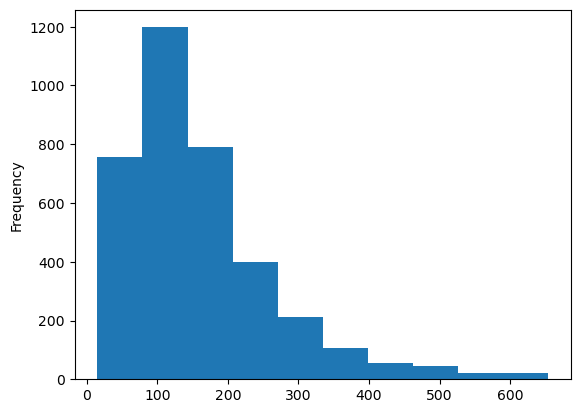

In [10]:
import matplotlib.pyplot as plt

review_df["Word count"].plot.hist()
plt.show()

Most reviews have a word count of 100-150 words, so people don't tend to write long reviews about BA

### Word cloud

Right now we have only the word count. What about the most popular words? We'll visualize a word cloud to see the top-100 words people use the most to describe the experience with BA.

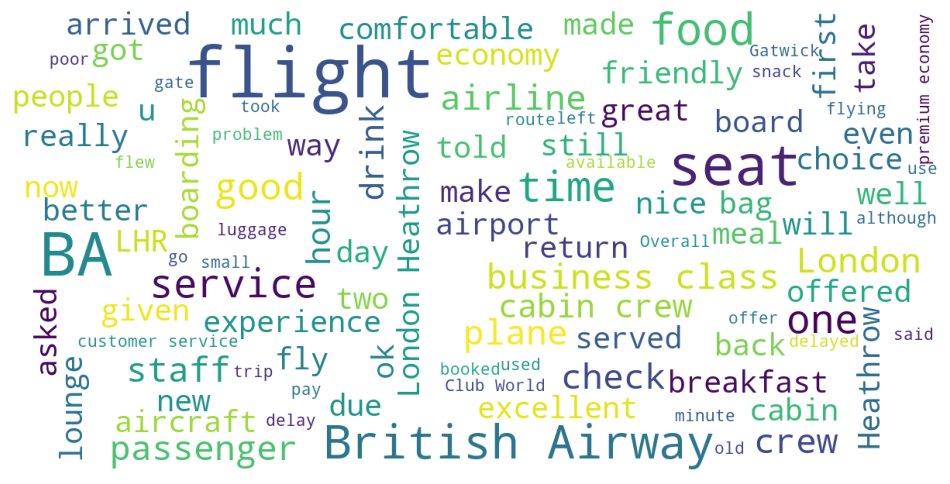

In [11]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=100,
    max_font_size=30,
    scale=3,
    random_state=1)
wordcloud = wordcloud.generate(" ".join(i for i in review_df["Review texts"].to_list()))
fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()


The most frequent words are the biggest ones. And they mention the company which is very logical. Next a bit less often service, seats, meals and other aspects are mentioned. Then comes the most interesting part - adjectives. We can see that there are a lot of positive ones - great, nice, ok, excellent, friendly, better, comfortable. But there are still not so good ones - delayed, problem (not an adjective but still negative), old (maybe not that negative), poor.

In conclusion, people tend to write the most about seats, food, service and the flight itself.

Judging from the picture, a hypothesis can be made - there are more positive reviews than negative ones. We'll check that using the sentiment analysis.

### Sentiment analysis

The first library we'll use for sentiment analysis is `textblob`. It returns a score from -1 to 1, -1 meaning negative, 1 meaning positive

In [12]:
from textblob import TextBlob

review_df["textblob_sentiment"] = review_df["Review texts"].apply(lambda x: TextBlob(x).sentiment.polarity)
review_df.head()

,Review texts,Word count,textblob_sentiment
0,Flight was delayed due to the inbound flight a...,168,0.004029
1,Fast and friendly check in (total contrast to ...,116,0.315104
2,I don't understand why British Airways is clas...,112,0.137222
3,I'm sure that BA have gradually made their eco...,166,0.027778
4,Customer Service does not exist. One world eme...,172,0.023684


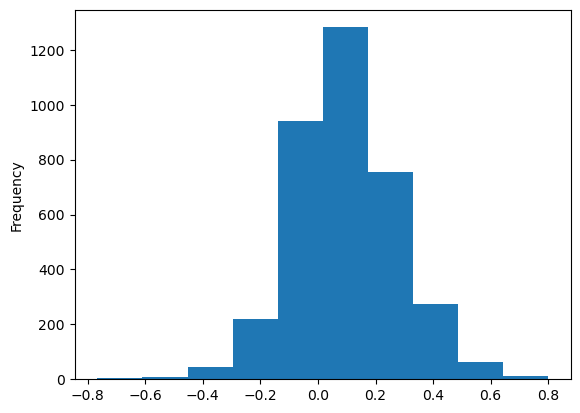

In [13]:
review_df["textblob_sentiment"].plot.hist()
plt.show()

As we can see from the histogram, `textblob` shows that there are more neutral-positive reviews than neutral-negative ones (from -0.1 to 0.3).

And in general, if we look at the far left (<0.3) and far right (>0.3), we can see that positive reviews are still more prevalent. Let's see what the second library - `nltk.sentiment.vader` - has to show

In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer


sen_an = SentimentIntensityAnalyzer()
review_df["vader_sentiment"] = review_df["Review texts"].apply(lambda x:sen_an.polarity_scores(x)['compound'])
review_df.head()

,Review texts,Word count,textblob_sentiment,vader_sentiment
0,Flight was delayed due to the inbound flight a...,168,0.004029,0.2598
1,Fast and friendly check in (total contrast to ...,116,0.315104,0.9841
2,I don't understand why British Airways is clas...,112,0.137222,0.9723
3,I'm sure that BA have gradually made their eco...,166,0.027778,0.7878
4,Customer Service does not exist. One world eme...,172,0.023684,-0.7497


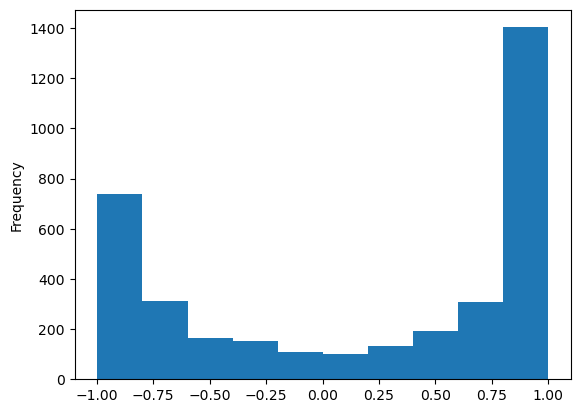

In [15]:
review_df["vader_sentiment"].plot.hist()
plt.show()

VADER is a more categorical than textblob. Yet it also shows that there are approximately twice as many positve reviews than negative ones.

To depict the results more clearly, we'll categorize the reviews using the scores and show their frequencies on a doubled bar chart.

For both of the scores we'll use the same strategy:
- from -0.05 to 0.05 - neutral
- lower than -0.05 - negative
- higher than 0.05 - positive

In [16]:
def score_interpreter(score):
    if -0.05 <= score <= 0.05:
        return "neutral"
    elif score < -0.5:
        return "negative"
    else:
        return "positve"
    
review_df["textblob_category"] = review_df["textblob_sentiment"].apply(score_interpreter)
review_df["vader_category"] = review_df["vader_sentiment"].apply(score_interpreter)
review_df.head()

,Review texts,Word count,textblob_sentiment,vader_sentiment,textblob_category,vader_category
0,Flight was delayed due to the inbound flight a...,168,0.004029,0.2598,neutral,positve
1,Fast and friendly check in (total contrast to ...,116,0.315104,0.9841,positve,positve
2,I don't understand why British Airways is clas...,112,0.137222,0.9723,positve,positve
3,I'm sure that BA have gradually made their eco...,166,0.027778,0.7878,neutral,positve
4,Customer Service does not exist. One world eme...,172,0.023684,-0.7497,neutral,negative


In [17]:
textblob_counts = review_df.groupby("textblob_category")["Review texts"].count().reset_index()
vader_counts = review_df.groupby("vader_category")["Review texts"].count().reset_index()

In [18]:
textblob_counts

,textblob_category,Review texts
0,negative,7
1,neutral,852
2,positve,2747


In [19]:
vader_counts

,vader_category,Review texts
0,negative,1137
1,neutral,49
2,positve,2420


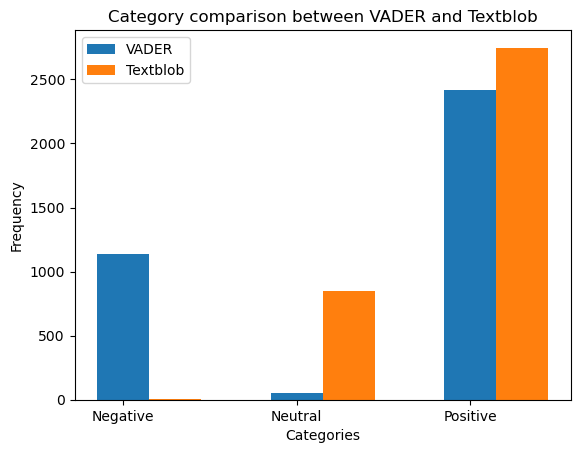

In [37]:
import numpy as np

labels = ["Negative", "Neutral", "Positive"]

textblob_categories = textblob_counts["Review texts"].to_list()
vader_categories = vader_counts["Review texts"].to_list()

x_axis = np.arange(len(labels))

plt.bar(x_axis, vader_categories, width=0.3, label = 'VADER')
plt.bar(x_axis + 0.3, textblob_categories, width=0.3, label = 'Textblob')
plt.xticks(x_axis, labels)
plt.xlabel("Categories")
plt.ylabel("Frequency")
plt.title("Category comparison between VADER and Textblob")
plt.legend()
plt.show()

Now it is clear, that from VADER's perspective, negative reviews make almost a third of all the reviews, which is not very good. As people don't leave neutral reviews on such websites (they tend to not do anything at all), we will use VADER's classification to further investigate the reviews.

### Positive and negative reviews investigation

By constructing a word cloud of positive reviews, let's find out what people like about BA

In [41]:
positive_reviews = review_df[review_df["vader_category"]=="positve"]
positive_reviews

,Review texts,Word count,textblob_sentiment,vader_sentiment,textblob_category,vader_category
0,Flight was delayed due to the inbound flight a...,168,0.004029,0.2598,neutral,positve
1,Fast and friendly check in (total contrast to ...,116,0.315104,0.9841,positve,positve
2,I don't understand why British Airways is clas...,112,0.137222,0.9723,positve,positve
3,I'm sure that BA have gradually made their eco...,166,0.027778,0.7878,neutral,positve
5,"Another really great pair of flights, on time,...",52,0.526970,0.9808,positve,positve
...,...,...,...,...,...,...
3600,Flew LHR - VIE return operated by bmi but BA a...,81,0.381837,0.9840,positve,positve
3602,LHR to HAM. Purser addresses all club passenge...,25,0.173214,0.8720,positve,positve
3603,My son who had worked for British Airways urge...,230,0.143148,0.4516,positve,positve
3604,London City-New York JFK via Shannon on A318 b...,33,0.351667,0.9148,positve,positve


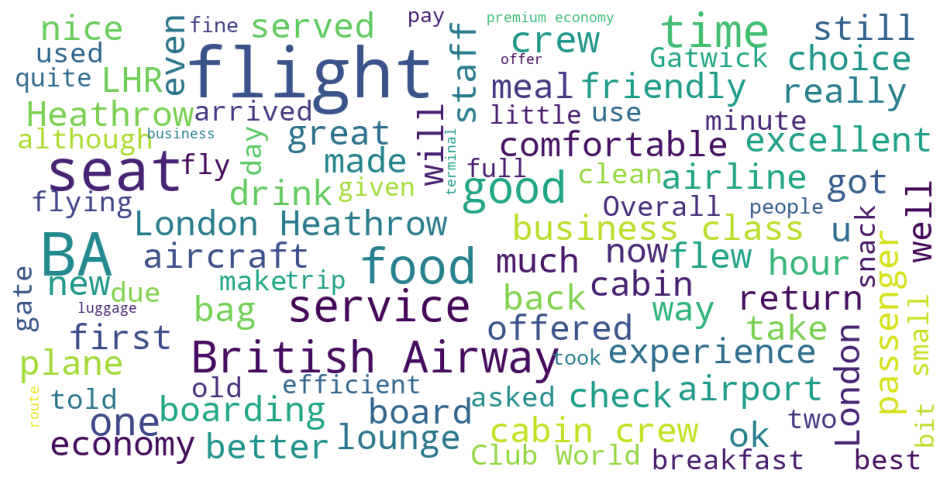

In [42]:
wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=100,
    max_font_size=30,
    scale=3,
    random_state=1)
wordcloud = wordcloud.generate(" ".join(i for i in positive_reviews["Review texts"].to_list()))
fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

From this image, we can say that people like the aspects of flight (boarding time, time spent flying), seats, meals, staff and service. So the basics are done right. Let's see what people dislike about BA

In [44]:
negative_reviews = review_df[review_df["vader_category"]=="negative"]
negative_reviews

,Review texts,Word count,textblob_sentiment,vader_sentiment,textblob_category,vader_category
4,Customer Service does not exist. One world eme...,172,0.023684,-0.7497,neutral,negative
6,Our A380 developed a fault taxiing to the runw...,187,0.007333,-0.6936,neutral,negative
7,Horrible airline. Does not care about their cu...,54,-0.158333,-0.7063,positve,negative
10,In Nov 2022 I booked and paid for a return jou...,196,0.080073,-0.9281,positve,negative
13,We arrived at Heathrow at 0600 to find our fli...,100,-0.200000,-0.9124,positve,negative
...,...,...,...,...,...,...
3581,Lanzarote to Gatwick on 13th April. Flight its...,131,0.172727,-0.6823,positve,negative
3588,BA 059 London to Cape Town April 29 2014 econo...,141,-0.155357,-0.7190,positve,negative
3593,Just got back from Bridgetown Barbados flying ...,123,-0.202500,-0.8763,positve,negative
3599,Flight from Heathrow to Toronto. Booked emerge...,68,0.066667,-0.6562,positve,negative


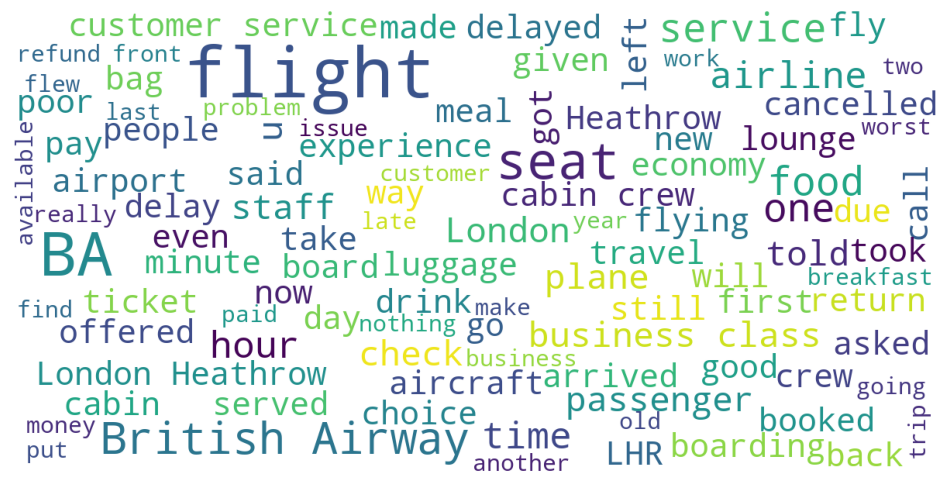

In [45]:
wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=100,
    max_font_size=30,
    scale=3,
    random_state=1)
wordcloud = wordcloud.generate(" ".join(i for i in negative_reviews["Review texts"].to_list()))
fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

Hmm, semms like people have the most issues with the company itself: customer service, return of the tickets, price. Also flights (experience in general, delays, cancellation) and seats are concerningly often appear in negative reviews. Maybe customers didn't like the time of the flight or weren't lucky to get a good seat for some reason

### Summary

- Most reviews are positive, however, about 30% of all reviews are negative
- People like the staff, meals, seats and the flight itself
- But there are problems with customer service, return polices, and sometimes flight experience is not satisfying

**What can be done**:
- improve customer support
- rework return polices and interaction with clients in general
- control the quality of seats, flight attendants, airpots, lounges